# Кластеризация

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
import matplotlib.pyplot as plt
%matplotlib inline

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

# 1. KMeans
Идея KMeans предельно проста - давайте метки точек обновлять в соответствии с ближайшим центроидом, а положения центроидов - в соответствие с с точками, и повторять этот процесс итерационно, пока не надоест. На картинке ниже показан KMeans с n_clusters=3

![](https://datasciencelab.files.wordpress.com/2013/12/p_n200_k3.gif)

## Сгенерируем данные

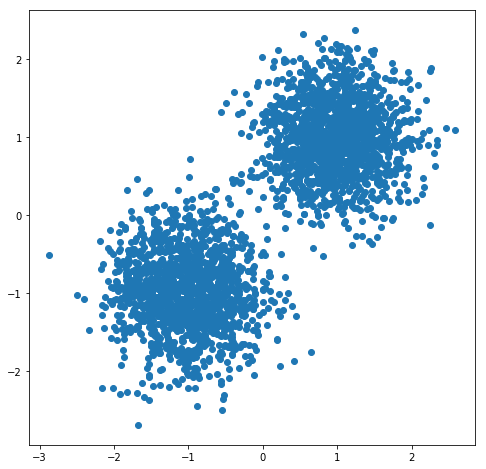

In [2]:
from sklearn.cluster import KMeans

from sklearn.datasets.samples_generator import make_blobs
np.random.seed(0)
centers = [[1, 1], [-1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, 
                            centers=centers, 
                            cluster_std=0.5)

def plot_cluster_data(X, c=[1]*X.shape[0], mu=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    if len(np.unique(c)) == 1:
        ax.plot(X[:,0], X[:,1], 'o')
    else:
        ix = np.where(c==1)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='red')
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ix = np.where(c==0)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='green')
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)
    if not mu is None:
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)        
    plt.show()
    
plot_cluster_data(X)


## Обучим KMeans

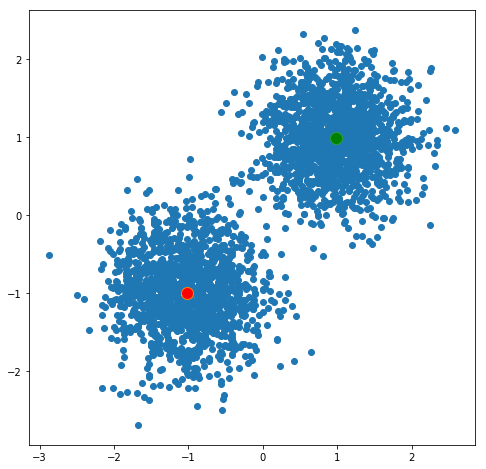

In [3]:
clst = KMeans(n_clusters=2, random_state=2342)
clst.fit(X)
mu = clst.cluster_centers_
plot_cluster_data(X, mu = mu)

## Посмотрим, как с каждым шагом меняется положение центроидов

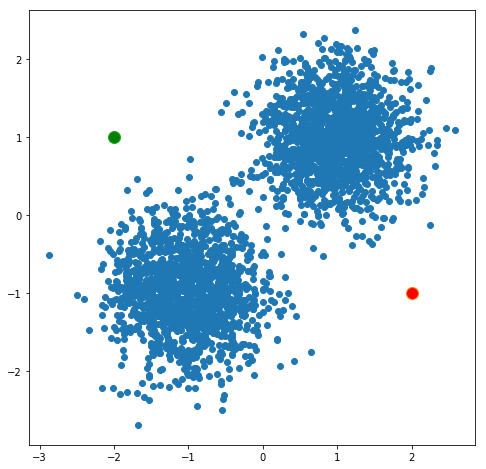

In [4]:
def update_labels(X, mu):
    c = np.argmax(np.c_[np.sum(np.power(X - mu[0,:], 2), axis=1), 
                        np.sum(np.power(X - mu[1,:], 2), axis=1)], 
                  axis=1)
    return c

def update_cluster_centers(X, c):
    ix = np.where(c==1)
    mu[0,:] = np.mean(X[ix,:], axis=1)
    ix = np.where(c==0)
    mu[1,:] = np.mean(X[ix,:], axis=1)
    return mu



k = 2
mu = np.array([[2.0,-1.0], [-2.0,1.0]])
plot_cluster_data(X, mu=mu)

Iteration 0:
...updating labels:


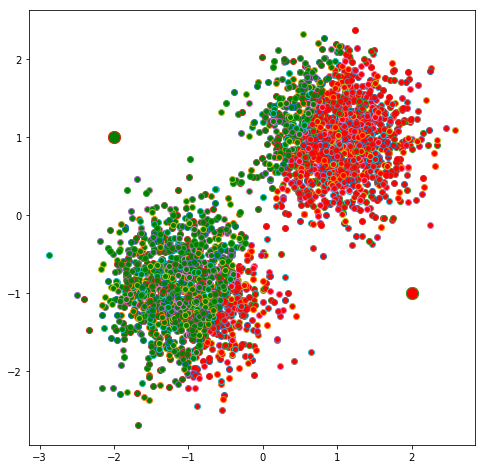

...updating centers:


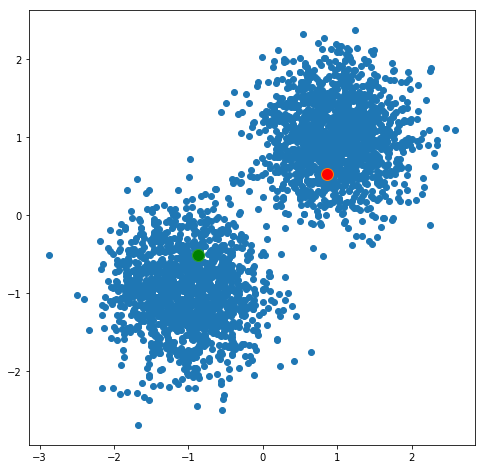

Iteration 1:
...updating labels:


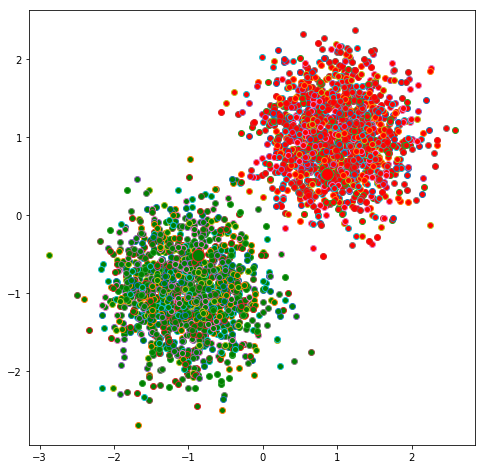

...updating centers:


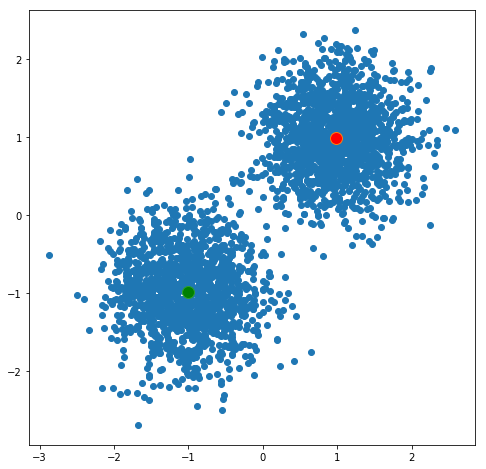

In [5]:
niter = 2
for it in range(niter):
    print('Iteration ' + str(it) + ':')
    c = update_labels(X, mu)
    print('...updating labels:')
    plot_cluster_data(X, c=c, mu=mu)
    print('...updating centers:')
    mu = update_cluster_centers(X, c)
    plot_cluster_data(X, mu=mu)

# Резюме
**Достоинства:**
* Быстрый
* Масштабируемый (есть готовые реализации на SparkML и Apache Mahout)
* Простой

**Недостатки;**
* Не умеет определять число кластеров

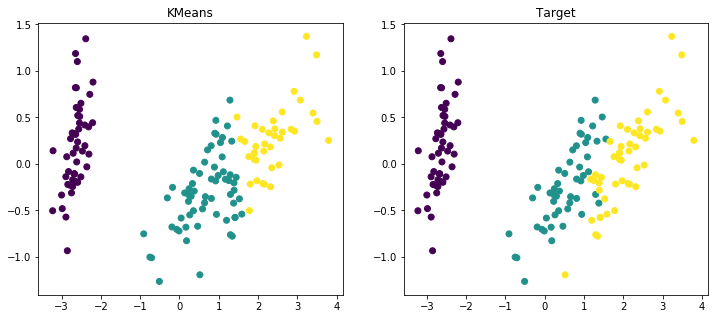

In [6]:
from sklearn.datasets import load_iris
X, y = load_iris()['data'], load_iris()['target']

from sklearn.decomposition import PCA

X_transform = PCA(n_components=2).fit_transform(X) # Сожмём до 2 признаков, чтобы было удобно визуализировать
from sklearn.cluster import KMeans

clst = KMeans(n_clusters=3)
preds = clst.fit_predict(X)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('KMeans')
plt.scatter(X_transform[:,0], X_transform[:,1], c=preds)

plt.subplot(122)
plt.title('Target')
plt.scatter(X_transform[:,0], X_transform[:,1], c=y) 

# Метрики качества для кластеризации

ARI

AMI

Homogenity

Completeness

V-measure

Silhouette

In [7]:
from sklearn import metrics

def get_metrics(X, y, preds):
    return {
        'ARI': metrics.adjusted_rand_score(y, preds),
        'AMI': metrics.adjusted_mutual_info_score(y, preds),
        'Homogenity': metrics.homogeneity_score(y, preds),
        'Completeness': metrics.completeness_score(y, preds),
        'V-measure': metrics.v_measure_score(y, preds),
        'Silhouette': metrics.silhouette_score(X, preds)}

get_metrics(X, y, preds)

{'ARI': 0.7302382722834697,
 'AMI': 0.7483723933229484,
 'Homogenity': 0.7514854021988338,
 'Completeness': 0.7649861514489815,
 'V-measure': 0.7581756800057784,
 'Silhouette': 0.5525919445213676}

# AffinityPropagation
Основная идея AffinityPropagation - устраивать между точками голосование по выбору лучшего кандидата на позицию центроида (губернатора) кластера (региона). В алгоритме три матрицы - S (близость между точками), R (ответственность, готовность каждой точки отдать свой голос второй) и A (доступность, насколько кандидат готов удовлетворять интересы своего избирателя)

**Параметры:**
* **affinity** в SkLearn - по какой формуле считать близость

![](https://habrastorage.org/files/c01/0c3/004/c010c30048194658aadc6f49915163a0.png)

![](https://hsto.org/files/9fc/34a/b55/9fc34ab559fb4be4b23928ce18619a28.png)

In [8]:
from sklearn.cluster import AffinityPropagation

clst = AffinityPropagation()
pred = clst.fit_predict(X)
get_metrics(X, y, pred)

{'ARI': 0.48033793286957843,
 'AMI': 0.5169514470691752,
 'Homogenity': 0.9149410296693686,
 'Completeness': 0.5276002057338901,
 'V-measure': 0.6692676280452976,
 'Silhouette': 0.35155761864245394}

In [9]:
n_clusters = len(clst.cluster_centers_)
n_clusters

7

# DBSCAN

Идея алгоритма - формировать точки в кластеры на основе их близости. Если в некотором радиусе R для точки не меньше N соседей, то точка относится к тому же кластеру, что и эти соседи. Если точек меньше, но >0, то это сомнительная точка. Если в окрестности точки нет ни одного соседа, то это выброс. Также можно сливать маленькие кластеры с более крупными

**Параметры:**
* R (**eps** в SkLearn) - радиус
* N (**min_samples** в SkLearn) - минимальное число соседей 
* **metric** в SkLearn - по какой формуле считать близость

![](https://hsto.org/files/0ba/54b/abe/0ba54babe162458bb9f8e004e5329cfa.png)

[Демо](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

In [10]:
from sklearn.cluster import DBSCAN

clst = DBSCAN()
pred = clst.fit_predict(X)
get_metrics(X, y, pred)

{'ARI': 0.5206185241703302,
 'AMI': 0.5543650737746607,
 'Homogenity': 0.5599460100861128,
 'Completeness': 0.6565579648058795,
 'V-measure': 0.6044156375501386,
 'Silhouette': 0.4858423545758963}

In [11]:
n_componens = len(clst.components_)
n_componens

117

# Кейс - кластеризация текста

Представьте, что Вы владелец интернет-магазина. Товаров очень много, отзывов к ним ещё больше. Задача: требуется сгруппировать отзывы на группы и понять, какие группы образуются

In [47]:
import pandas as pd
data = pd.read_csv('../data/amazon_cells_labelled.txt', sep='\t', names=['text', 'label'])
X, y = data['text'], data['label']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [55]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

model = Pipeline([('preprocessing', TfidfVectorizer()),
#                   ('pca', TruncatedSVD(n_components=100)),
               ('model', KMeans(n_clusters=10))
               ])

model.fit(X_train)

Pipeline(memory=None,
     steps=[('preprocessing', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf...0, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [56]:
cluster_number = 3
cluster_samples = np.array(X_test)[np.argwhere(model.predict(X_test)==cluster_number).squeeze()]
for text in cluster_samples[:10]:
    print(text)
    print('*************************')

I posted more detailed comments under the grey or black phone, but i have the Fire Red and it's a great color!
*************************
I have two more years left in this contract and I hate this phone.
*************************
In the span of an hour, I had two people exclaim "Whoa - is that the new phone on TV?!?
*************************
This is a beautiful phone.
*************************
Linksys should have some way to exchange a bad phone for a refurb unit or something!
*************************
Does not charge the Cingular (ATT) 8525 phone.
*************************
I find this inexcusable and so will probably be returning this phone and perhaps changing carriers.
*************************
I connected my wife's bluetooth,(Motorola HS850) to my phone and it worked like a charm whether the phone was in my pocket or the case.
*************************
I'm still infatuated with this phone.
*************************
I have 2-3 bars on my cell phone when I am home, but you cant not h

In [57]:
cluster_number = 2
cluster_samples = np.array(X_test)[np.argwhere(model.predict(X_test)==cluster_number).squeeze()]
for text in cluster_samples[:10]:
    print(text)
    print('*************************')

Don't waste your $$$ on this one.
*************************
What a waste of money and time!.
*************************
Terrible product, and waste of money!
*************************


In [58]:
cluster_number = 1
cluster_samples = np.array(X_test)[np.argwhere(model.predict(X_test)==cluster_number).squeeze()]
for text in cluster_samples[:10]:
    print(text)
    print('*************************')

The range is very decent, I've been able to roam around my house with the phone in the living room with no reception/sound quality issues.
*************************
I received my orders well within the shipping timeframe, everything was in good working order and overall, I am very excited to have this source.
*************************
Very happy with this product.
*************************
it did not work in my cell phone plug i am very up set with the charger!.
*************************
I own a Jabra Earset and was very happy with it, but the sound quality, especially outgoing, on this is better.
*************************
The headset fulfills my requirements so I am happy with my purchase.
*************************
I was very pleased to see that I could replace my well travled swivel holster for my Blackberry flip.
*************************
It dit not work most of the time with my Nokia 5320.
*************************
I'm using it with an iriver SPINN (with case) and it fits fine.
***

In [59]:
cluster_number = 5
cluster_samples = np.array(X_test)[np.argwhere(model.predict(X_test)==cluster_number).squeeze()]
for text in cluster_samples[:10]:
    print(text)
    print('*************************')

It's been my choice headset for years.Great sound; good volume; good noise cancellation.
*************************
good item, low price.
*************************
It's very attractive and appears to be of good quality.
*************************
Not a good bargain.
*************************
The price was very good and with the free shipping and all it was a good purchase.
*************************
I love the camera, it's really pretty good quality.
*************************
Good audio quality.
*************************


In [60]:
cluster_number = 7
cluster_samples = np.array(X_test)[np.argwhere(model.predict(X_test)==cluster_number).squeeze()]
for text in cluster_samples[:10]:
    print(text)
    print('*************************')

This is a great phone!.
*************************
Great for using with your home stereo.
*************************
And the sound quality is great.
*************************
Headset works great & was packaged nicely to avoid any damage.
*************************
Great charger.
*************************
Great choice!
*************************
The battery works great!
*************************
New Battery works great in phone.
*************************
Great phone.
*************************
Great product and price.
*************************


## Посмотрим, что будет при кластеризации на два класса

In [71]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

model = Pipeline([('preprocessing', TfidfVectorizer()),
#                   ('pca', TruncatedSVD(n_components=100)),
               ('model', KMeans(n_clusters=2))
               ])

model.fit(X_train)
preds = model.predict(X_test)

from sklearn.metrics import accuracy_score
max(accuracy_score(y_test, preds), accuracy_score(y_test, 1-preds))

0.61

In [72]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

model = Pipeline([('preprocessing', TfidfVectorizer()),
                  ('pca', TruncatedSVD(n_components=100)),
               ('model', KMeans(n_clusters=2))
               ])

model.fit(X_train)
preds = model.predict(X_test)

from sklearn.metrics import accuracy_score
max(accuracy_score(y_test, preds), accuracy_score(y_test, 1-preds))

0.595

# Полезные ссылки

* [Список](http://scikit-learn.org/stable/modules/clustering.html) методов кластеризации в SkLearn с описанием того, когда какой использовать
* https://habr.com/post/101338/
* https://habr.com/company/ods/blog/325654/